In [8]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1. 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TSLA.csv')
data = df[['Open', 'High', 'Low', 'Close']].values

In [14]:
window = 20
target_col = 3
train_size = int(len(data) * 0.8)

train_raw = data[-train_size:]          # 뒤 80%를 학습
test_raw  = data[-train_size - window:] # 그 앞을 테스트용 시퀀스로

In [15]:
# 2. 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(data)                  # 전체
scaler_y.fit(data[:, [target_col]]) # 전체

train_X_scaled = scaler_X.transform(train_raw)
train_y_scaled = scaler_y.transform(train_raw[:, [target_col]])

test_X_scaled  = scaler_X.transform(test_raw)
test_y_scaled  = scaler_y.transform(test_raw[:, [target_col]])

In [16]:
def make_xy_multivar(X_scaled, y_scaled, window):
    Xs, ys = [], []
    for i in range(len(X_scaled) - window):
        Xs.append(X_scaled[i:i+window, :])
        ys.append(y_scaled[i+window, 0])
    return np.array(Xs), np.array(ys)[:, None]

x_train, y_train = make_xy_multivar(train_X_scaled, train_y_scaled, window)
x_test,  y_test  = make_xy_multivar(test_X_scaled,  test_y_scaled,  window)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=(window,4)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=8,
    shuffle=False,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.6892e-04
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1936e-04
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.8109e-04
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2475e-04
Epoch 5/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7251e-04
Epoch 6/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.2645e-05
Epoch 7/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8777e-05
Epoch 8/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3537e-05
Epoch 9/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7906e-05
Epoch 10/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.2088e-05
Epoch 11/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.6925e-05
Epoch 12/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7523e-05
Epoch 13/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1025e-05
Epoch 14/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.2688e-05
Epoch 15/50


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test MSE (price): 2117.6496089367806


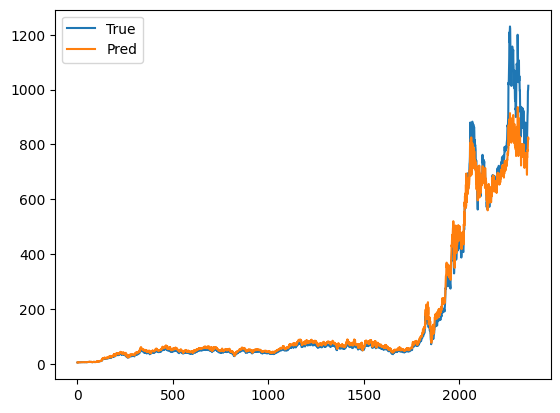

In [18]:
# 5. 예측
pred_test  = model.predict(x_test)

y_test_inv   = scaler_y.inverse_transform(y_test)
pred_test_inv = scaler_y.inverse_transform(pred_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_inv, pred_test_inv)
print("Test MSE (price):", mse)

plt.plot(y_test_inv, label='True')
plt.plot(pred_test_inv, label='Pred')
plt.legend(); plt.show()